#**유통 판매량 예측 및 재고 최적화**
## **단계3 : 모델링 및 비즈니스 평가**

# **0.미션**

* 단계1 다양한 모델링 수행
    * LSTM, CNN 등을 이용해서 다양한 시계열 모델링 수행
    * 성능 상위 2~3개 모델 선정
* 단계2 데이터 파이프라인 구축
    * test 데이터(raw data)로 부터 예측에 사용할 수 있는 형태로 데이터를 만드는 과정을 하나의 함수로 엮기
* 단계3 비즈니스 평가
    * 단계1에서 선정된 모델에 대해 test셋으로 평균 재고액 평가 수행

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [631]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [632]:
path = '/content/drive/MyDrive/KT_aivle/DNN, RNN/Mini_project_6/'
test_path = '/content/drive/MyDrive/KT_aivle/DNN, RNN/Mini_project_6/Day_2/1.data/'

### **(2) 라이브러리 설치 및 불러오기**

In [633]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten, Bidirectional
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [634]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [635]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

In [636]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

In [637]:
def make_dataset(Product_ID):

    # 1. 기본 데이터 준비
    leadTime = products.loc[products['Product_ID']==Product_ID, 'LeadTime'].values[0]
    temp1 = sales.loc[(sales['Store_ID']==44) & (sales['Product_ID']==Product_ID), ['Date','Qty']]
    temp2 = orders.loc[orders['Store_ID']==44, ['Date','CustomerCount']]
    temp3 = pd.merge(temp1, temp2)
    temp3['target'] = temp3['Qty'].shift(-leadTime)
    temp3.dropna(inplace = True)

    # 2. feature engineering
    # 2.1 날짜 요소 추출
    temp3['WeekDay'] = temp3['Date'].dt.day_name()
    temp3['Month'] = temp3['Date'].dt.month


    # 2.2 동일 카테고리 판매량 합계
    Category = products.loc[products['Product_ID'].isin([Product_ID]), 'Category'].to_list()
    Product_IDs = products.loc[products['Category'].isin(Category), 'Product_ID'].to_list()
    temp4 = sales.loc[(sales['Store_ID']==44) & (sales['Product_ID'].isin(Product_IDs))].groupby('Date', as_index = False)['Qty'].sum()
    temp4.columns = ['Date', 'Category_Qty']
    temp3 = pd.merge(temp3, temp4, how = 'left')

    # 2.3 동일 지역 방문객 수
    City = stores.loc[stores['Store_ID']==44, 'City'].values[0]
    Store_IDs = stores.loc[stores['City']==City, 'Store_ID'].to_list()
    temp5 = orders.loc[orders['Store_ID'].isin(Store_IDs)].groupby('Date', as_index = False)['CustomerCount'].sum()
    temp5.columns = ['Date', 'City_CustCount']
    temp3 = pd.merge(temp3, temp5, how = 'left')

    # 2.4 oil price MA14
    temp3 = pd.merge(temp3, oil_price, how = 'left')
    temp3['WTI_Price'] = temp3['WTI_Price'].rolling(14, min_periods=1).mean()

    return temp3

In [638]:
def preproc(data, y_scale = False) :
    target = 'target'
    x = data.drop(['Date', target], axis = 1)
    y = data.loc[:, target]

    # 가변수화
    x['WeekDay'] = pd.Categorical(x['WeekDay'], categories = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday' ])
    x['Month'] = pd.Categorical(x['Month'], categories = [1,2,3,4,5,6,7,8,9,10,11,12])
    x = pd.get_dummies(x, columns = ['WeekDay','Month',])

    # 스케일링
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)

    # y scale
    if y_scale == True :
        y_min, y_max = y.min(), y.max()
        y = (y - y_min) / (y_max - y_min)
    else :
        y_min, y_max = np.nan, np.nan

    # 분할
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 60, shuffle = False)

    return x_train, x_val, y_train, y_val, scaler, y_min, y_max

### **(3) 데이터 불러오기**

* **세부 요구사항**
    - 상품별로 저장한 데이터를 불러오시오.

In [639]:
data03 = make_dataset(3)
data03.head()

,Date,Qty,CustomerCount,target,WeekDay,Month,Category_Qty,City_CustCount,WTI_Price
0,2014-01-02,9853.0,4422,15153.0,Thursday,1,10142.0,45969,95.140000
1,2014-01-03,8647.0,4167,15606.0,Friday,1,8980.0,42386,94.400000
2,2014-01-04,15153.0,5341,7900.0,Saturday,1,15684.0,52293,94.400000
3,2014-01-05,15606.0,5123,7188.0,Sunday,1,15606.0,49199,94.400000
4,2014-01-06,7900.0,3917,8800.0,Monday,1,8083.0,39105,93.973333


In [640]:
data12 = make_dataset(12)
data12.head()

,Date,Qty,CustomerCount,target,WeekDay,Month,Category_Qty,City_CustCount,WTI_Price
0,2014-01-02,9647.0,4422,14188.0,Thursday,1,15195.550,45969,95.140000
1,2014-01-03,8879.0,4167,14490.0,Friday,1,13952.689,42386,94.400000
2,2014-01-04,14188.0,5341,7614.0,Saturday,1,22059.125,52293,94.400000
3,2014-01-05,14490.0,5123,7124.0,Sunday,1,22443.851,49199,94.400000
4,2014-01-06,7614.0,3917,8683.0,Monday,1,11853.281,39105,93.973333


In [641]:
data42 = make_dataset(42)
data42.head()

,Date,Qty,CustomerCount,target,WeekDay,Month,Category_Qty,City_CustCount,WTI_Price
0,2014-01-02,76.0,4422,78.0,Thursday,1,1962.62200,45969,95.140000
1,2014-01-03,74.0,4167,88.0,Friday,1,2144.99700,42386,94.400000
2,2014-01-04,78.0,5341,65.0,Saturday,1,2773.83000,52293,94.400000
3,2014-01-05,88.0,5123,78.0,Sunday,1,2542.78700,49199,94.400000
4,2014-01-06,65.0,3917,73.0,Monday,1,1284.36197,39105,93.973333


# **2.모델링**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.
    * 데이터 파이프라인 함수 작성하기
        * input : raw data
        * output : x_train, x_val, y_train, y_val
        * 원본 데이터에서 일부를 떼어 놓고, 파이프라인 함수를 테스트 해 봅시다.

In [642]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

In [643]:
def preproc3d(data, timesteps, y_scale = False) :
    target = 'target'
    x = data.drop(['Date', target], axis = 1)
    y = data.loc[:, target]

    # 가변수화
    x['WeekDay'] = pd.Categorical(x['WeekDay'], categories = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday' ])
    x['Month'] = pd.Categorical(x['Month'], categories = [1,2,3,4,5,6,7,8,9,10,11,12])
    x = pd.get_dummies(x, columns = ['WeekDay','Month',])
    col_names = list(x)


    # 스케일링
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x, columns=col_names)

    # y scale
    if y_scale == True :
        y_min, y_max = y.min(), y.max()
        y = (y - y_min) / (y_max - y_min)
    else :
        y_min, y_max = np.nan, np.nan

    # 3차원 변환
    x3, y3 = temporalize(x, y, timesteps)

    # 분할
    x_train, x_val, y_train, y_val = train_test_split(x3, y3, test_size = 120, shuffle = False)

    return x_train, x_val, y_train, y_val, scaler, y_min, y_max

## **(1) LSTM 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [644]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(data03, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(2853.0, 25413.0, (1018, 7, 24), (120, 7, 24))

* **모델링**

In [645]:
clear_session()

_, ts, nfeat = x_train.shape

model03_01 = Sequential([LSTM(4, input_shape = (ts, nfeat) ),
                         Dense(1)])
model03_01.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 464       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 469 (1.83 KB)
Trainable params: 469 (1.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/50
32/32 [==============================] - 2s 19ms/step - loss: 0.1642 - val_loss: 0.1298
Epoch 2/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0767 - val_loss: 0.0768
Epoch 3/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0513 - val_loss: 0.0641
Epoch 4/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0390 - val_loss: 0.0572
Epoch 5/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0322 - val_loss: 0.0543
Epoch 6/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0277 - val_loss: 0.0513
Epoch 7/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0245 - val_loss: 0.0454
Epoch 8/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0220 - val_loss: 0.0446
Epoch 9/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0199 - val_loss: 0.0415
Epoch 10/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0181 - val_loss: 0.0384
Epoch 11/50
32/32

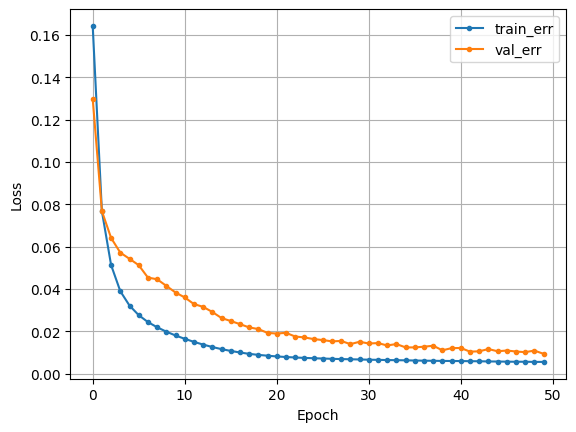

In [646]:
model03_01.compile(optimizer = 'adam', loss = 'mse')
hist = model03_01.fit(x_train, y_train, epochs = 50, validation_data =(x_val,y_val), verbose = 1).history
dl_history_plot(hist)

In [647]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model03_01.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 [==============================] - 0s 3ms/step
MAE :  1594.4321655273438
MAPE :  0.13307862129174283
R2 :  0.5977386595466236


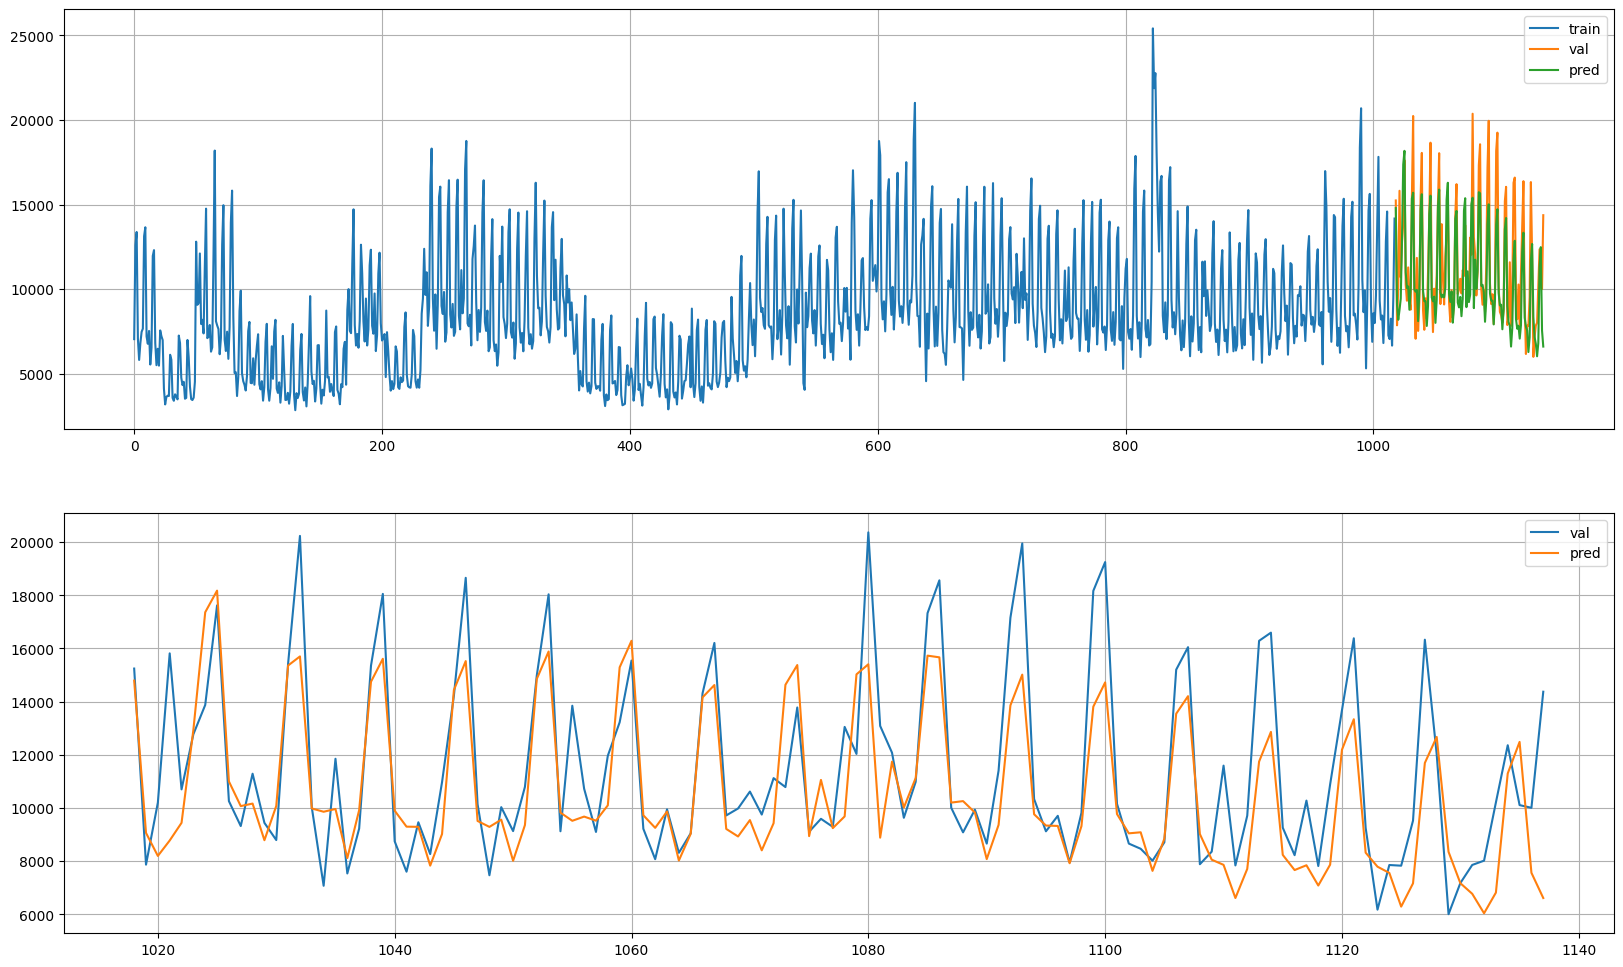

In [648]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [649]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(data12, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(4390.0, 37106.0, (1018, 7, 24), (120, 7, 24))

* **모델링**

In [650]:
clear_session()

_, ts, nfeat = x_train.shape

model12_01 = Sequential([LSTM(4, input_shape = (ts, nfeat) ),
                         Dense(1)])
model12_01.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 464       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 469 (1.83 KB)
Trainable params: 469 (1.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


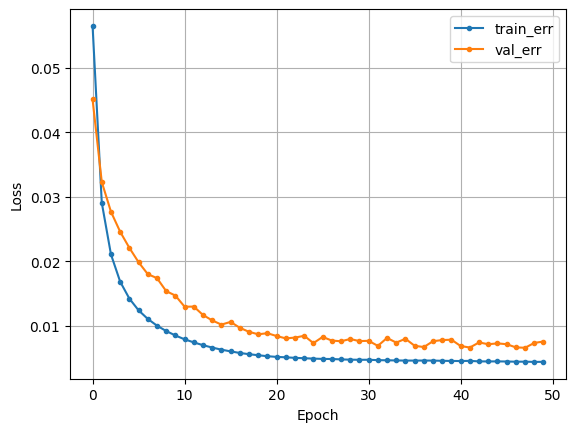

In [651]:
model12_01.compile(optimizer = 'adam', loss = 'mse')
hist = model12_01.fit(x_train, y_train, epochs = 50, validation_data =(x_val,y_val), verbose = 0).history
dl_history_plot(hist)

In [652]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model12_01.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 [==============================] - 0s 4ms/step
MAE :  2276.6933715820314
MAPE :  0.17181347226832736
R2 :  0.3733977076484122


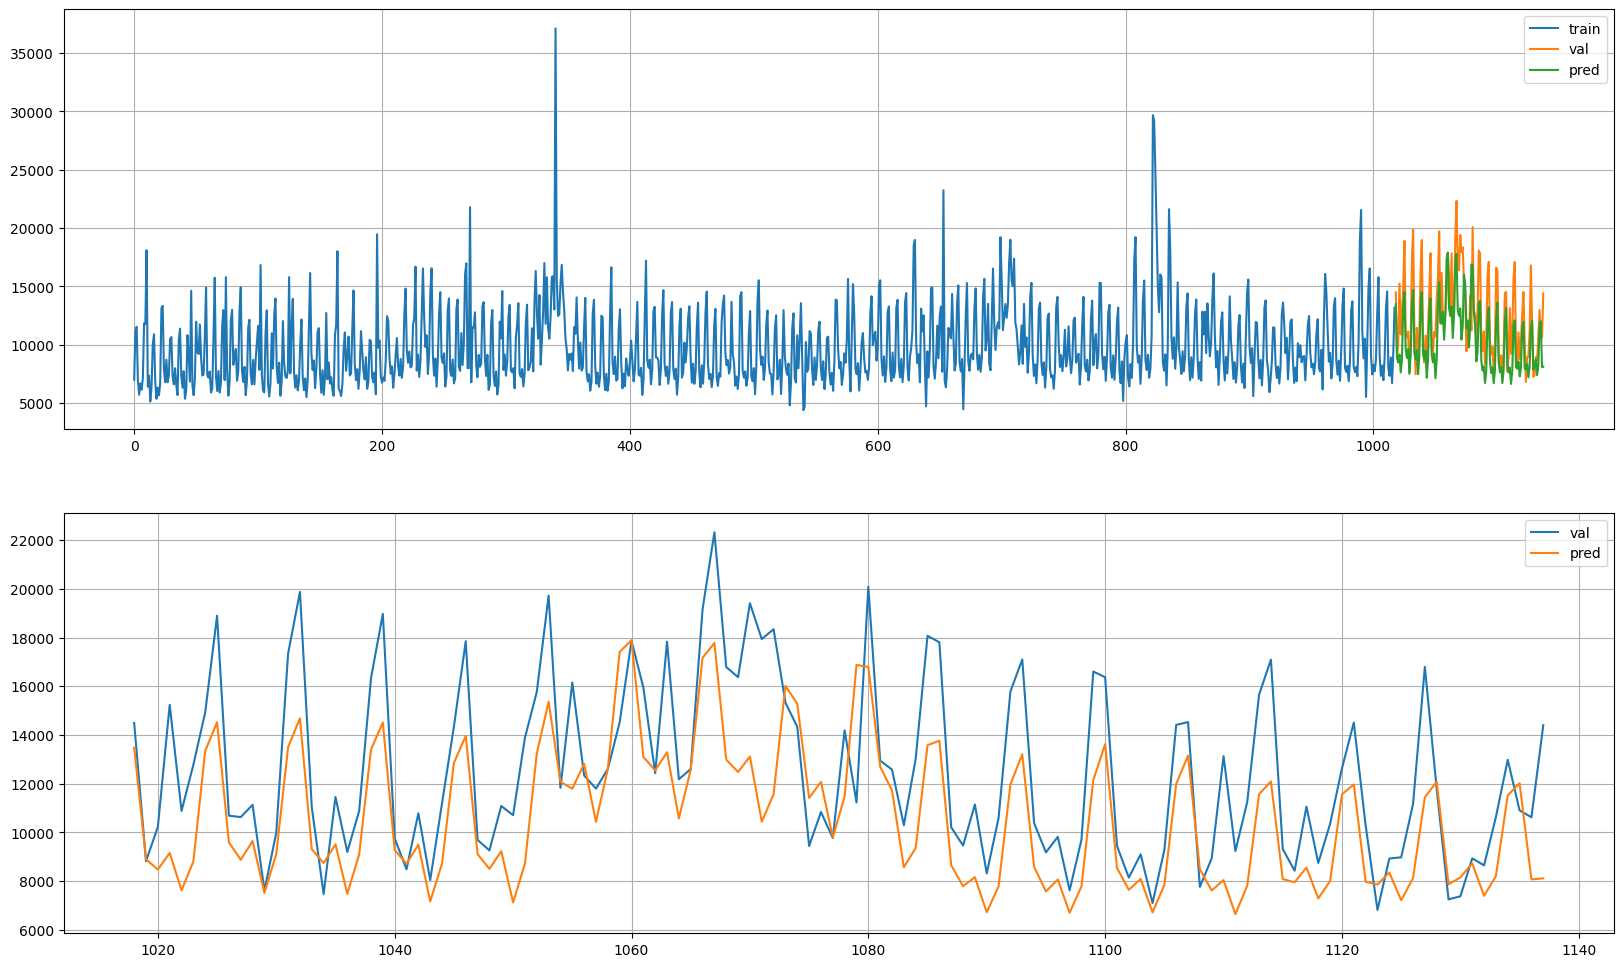

In [653]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [654]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(data42, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(45.0, 196.0, (1018, 7, 24), (120, 7, 24))

* **모델링**

In [655]:
clear_session()

_, ts, nfeat = x_train.shape

model42_01 = Sequential([LSTM(4, input_shape = (ts, nfeat) ),
                         Dense(1)])
model42_01.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 464       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 469 (1.83 KB)
Trainable params: 469 (1.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


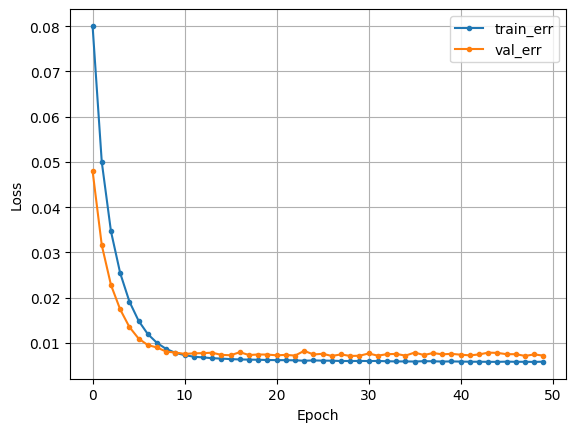

In [656]:
model42_01.compile(optimizer = 'adam', loss = 'mse')
hist = model42_01.fit(x_train, y_train, epochs = 50, validation_data=(x_val, y_val), verbose = 0).history
dl_history_plot(hist)

In [657]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model42_01.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 [==============================] - 0s 3ms/step
MAE :  9.9775772412618
MAPE :  0.10352764801487148
R2 :  0.6973184476010035


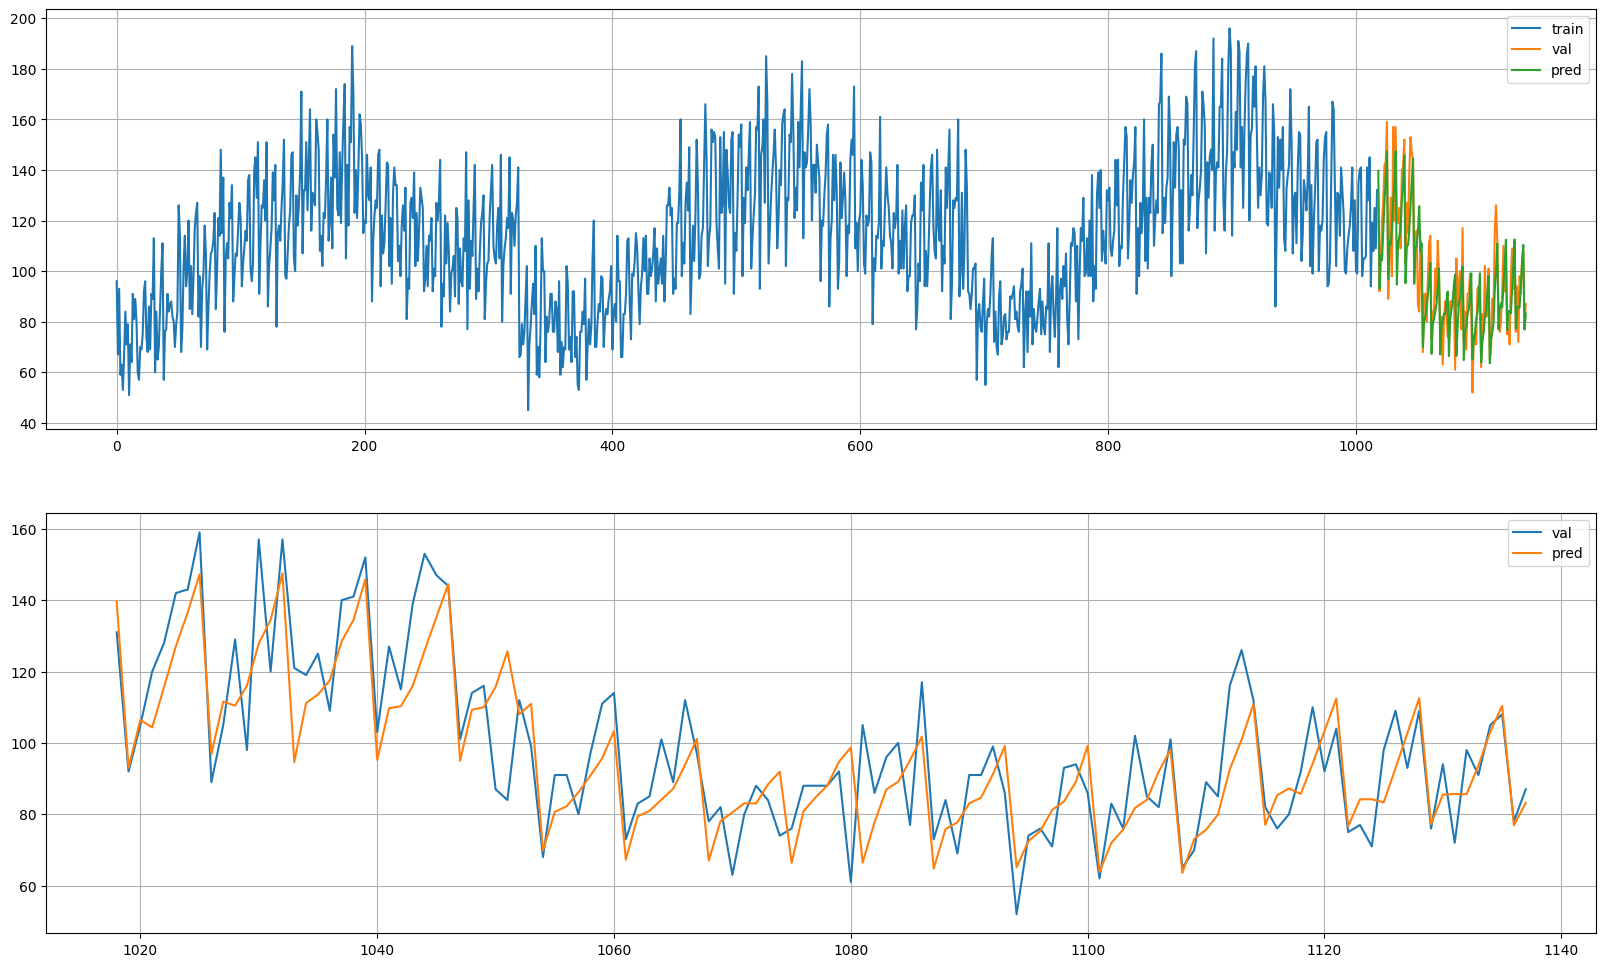

In [658]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

## **(2) CNN 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [659]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(data03, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(2853.0, 25413.0, (1018, 7, 24), (120, 7, 24))

* **모델링**

In [660]:
clear_session()

_, ts, nfeat = x_train.shape

model03_01 = Sequential([Conv1D(4, 3, input_shape = (ts, nfeat), activation='relu', padding = 'same'),
                         Flatten(),
                         Dense(1)])
model03_01.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 4)              292       
                                                                 
 flatten (Flatten)           (None, 28)                0         
                                                                 
 dense (Dense)               (None, 1)                 29        
                                                                 
Total params: 321 (1.25 KB)
Trainable params: 321 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


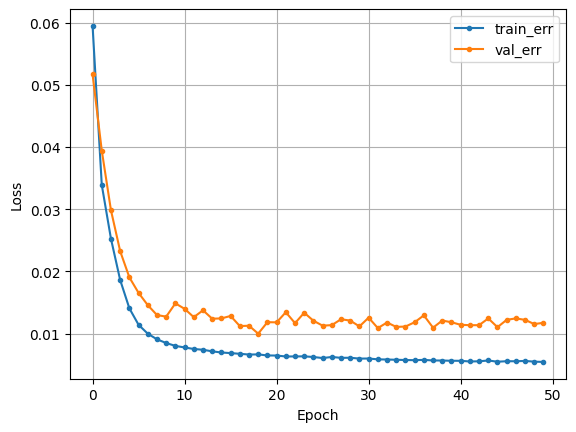

In [661]:
model03_01.compile(optimizer = 'adam', loss = 'mse')
hist = model03_01.fit(x_train, y_train, epochs = 50, validation_data = (x_val, y_val), verbose = 0).history
dl_history_plot(hist)

In [662]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model03_01.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 [==============================] - 0s 3ms/step
MAE :  1841.6828287760416
MAPE :  0.15371016133828697
R2 :  0.5009177047254305


In [683]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

ValueError: Length of values (23) does not match length of index (120)

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [664]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(data12, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(4390.0, 37106.0, (1018, 7, 24), (120, 7, 24))

* **모델링**

In [665]:
clear_session()

_, ts, nfeat = x_train.shape

model12_01 = Sequential([Conv1D(4, 3, input_shape = (ts, nfeat), activation='relu', padding = 'same'),
                         Flatten(),
                         Dense(1)])
model12_01.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 4)              292       
                                                                 
 flatten (Flatten)           (None, 28)                0         
                                                                 
 dense (Dense)               (None, 1)                 29        
                                                                 
Total params: 321 (1.25 KB)
Trainable params: 321 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


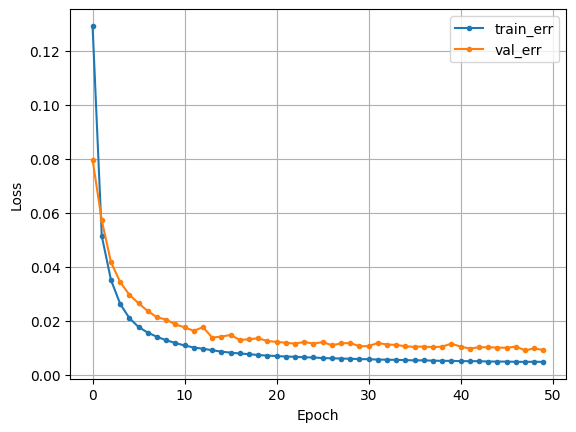

In [666]:
model12_01.compile(optimizer = 'adam', loss = 'mse')
hist = model12_01.fit(x_train, y_train, epochs = 50,  validation_data = (x_val, y_val), verbose = 0).history
dl_history_plot(hist)

In [667]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model12_01.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 [==============================] - 0s 3ms/step
MAE :  2435.1717244466145
MAPE :  0.18869684335084477
R2 :  0.24424705358900556


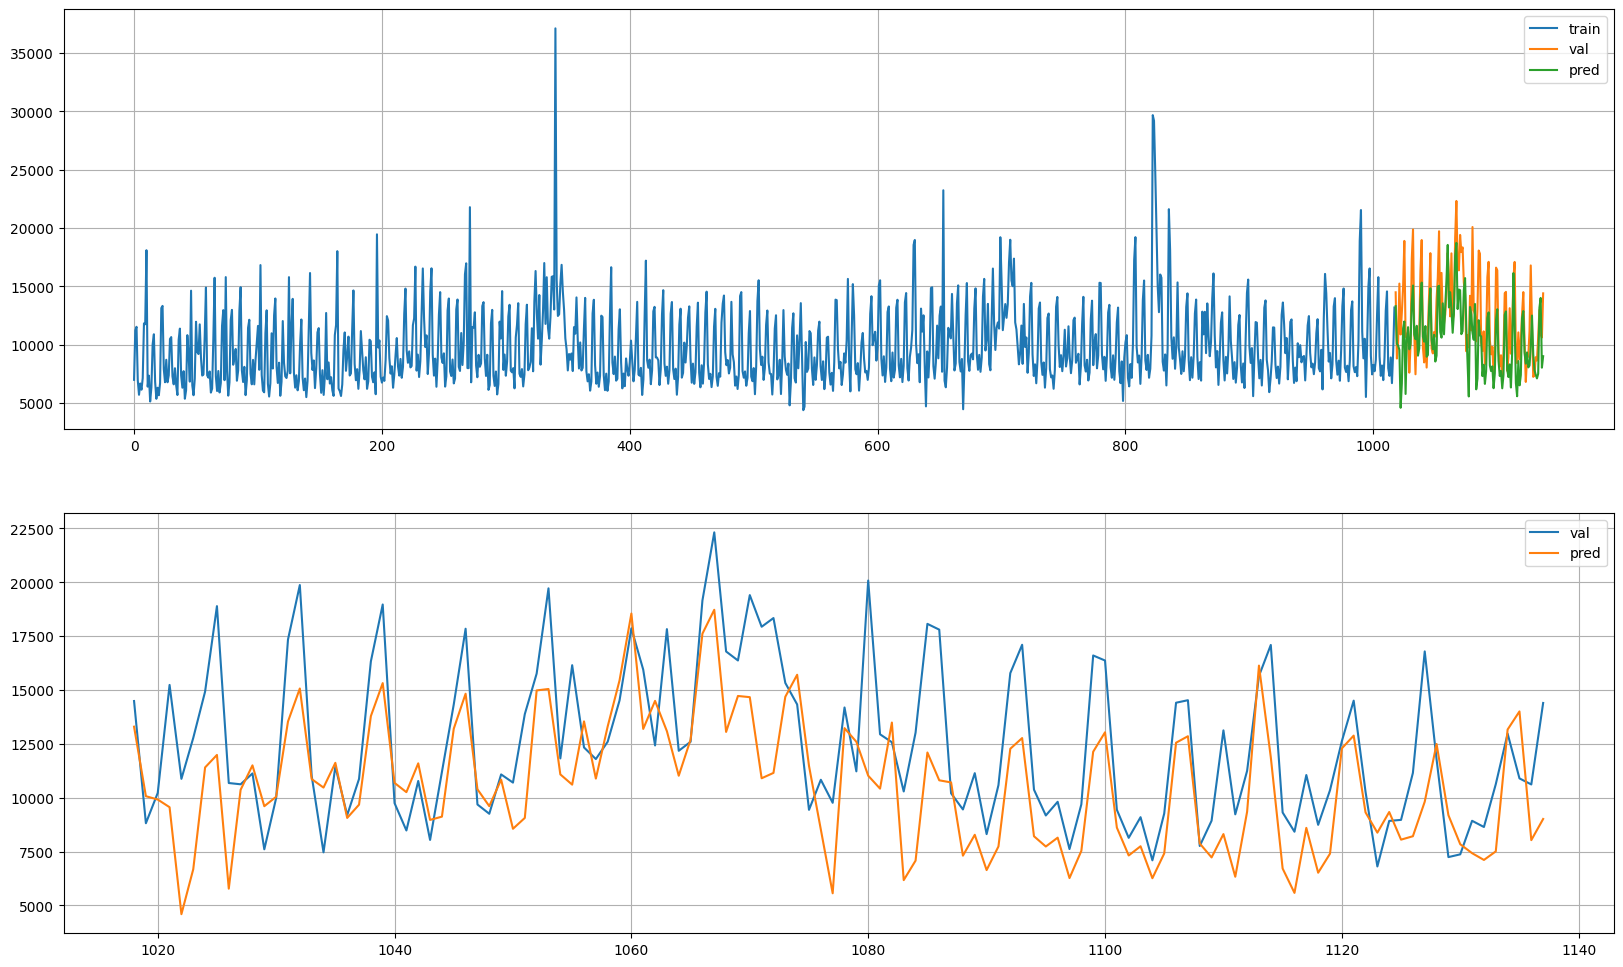

In [668]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [669]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(data42, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(45.0, 196.0, (1018, 7, 24), (120, 7, 24))

* **모델링**

In [670]:
clear_session()

_, ts, nfeat = x_train.shape

model42_01 = Sequential([Conv1D(4, 3, input_shape = (ts, nfeat), activation='relu', padding = 'same'),
                         Flatten(),
                         Dense(1)])
model42_01.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 4)              292       
                                                                 
 flatten (Flatten)           (None, 28)                0         
                                                                 
 dense (Dense)               (None, 1)                 29        
                                                                 
Total params: 321 (1.25 KB)
Trainable params: 321 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


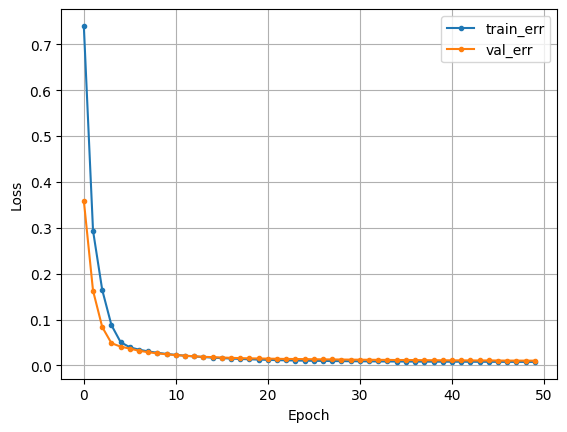

In [671]:
model42_01.compile(optimizer = 'adam', loss = 'mse')
hist = model42_01.fit(x_train, y_train, epochs = 50,  validation_data = (x_val, y_val), verbose = 0).history
dl_history_plot(hist)

In [672]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model42_01.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 [==============================] - 0s 3ms/step
MAE :  12.067887083689373
MAPE :  0.12437734554636756
R2 :  0.559519528906735


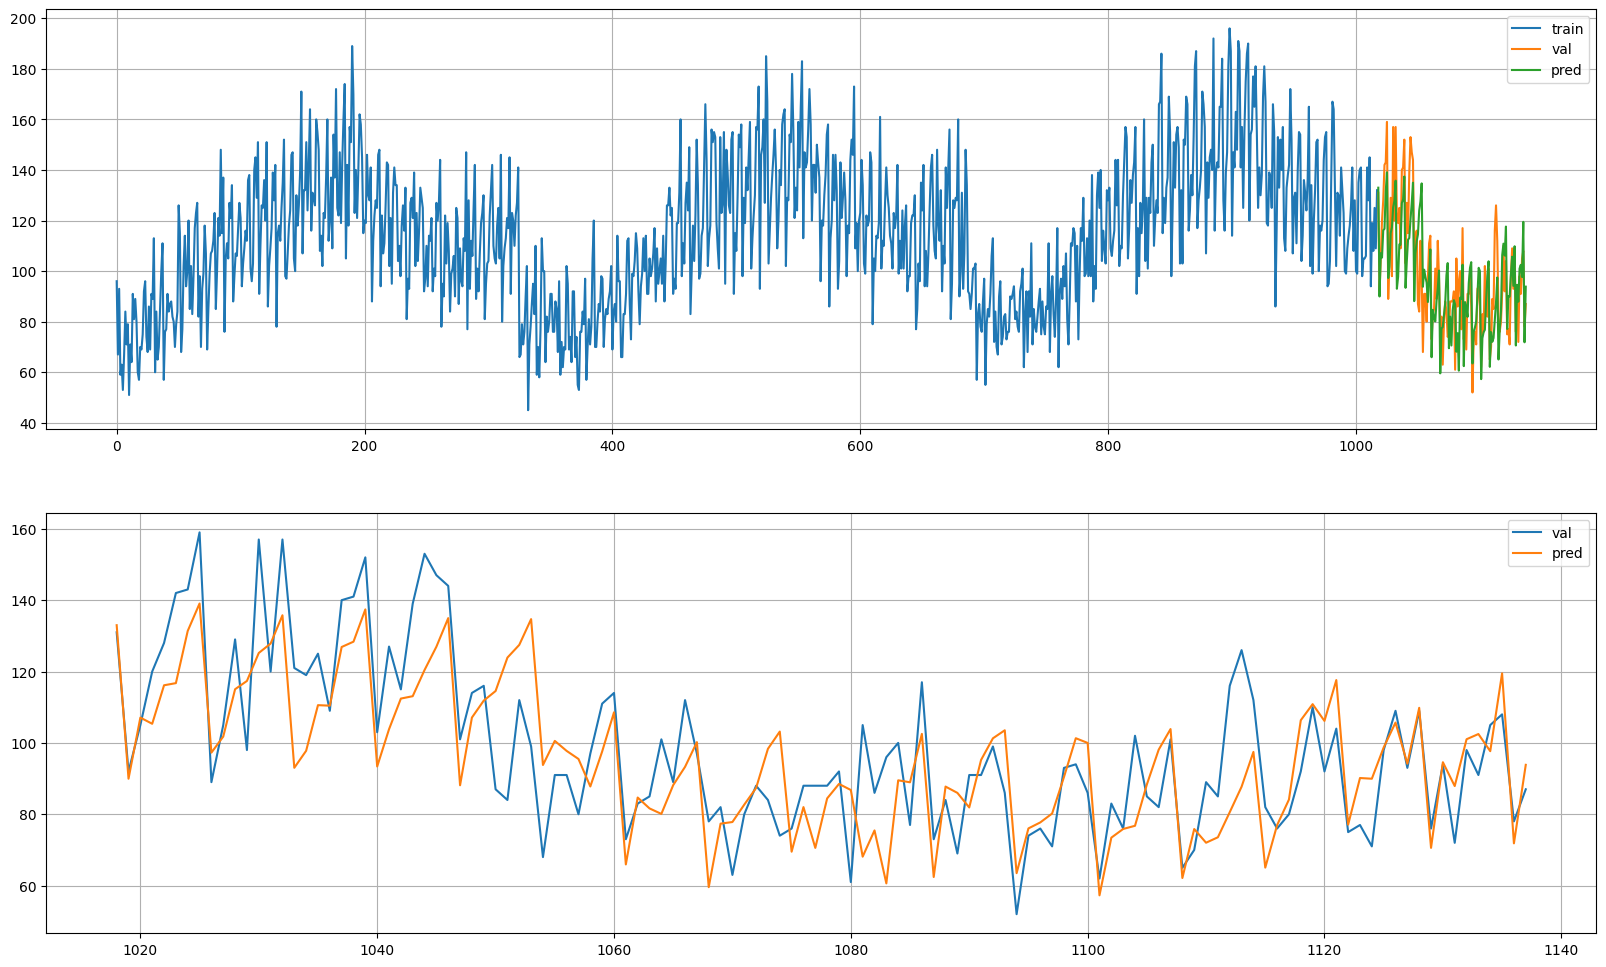

In [673]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

# **3.데이터 파이프라인 생성**

* 세부 요구사항
    * 데이터 파이프라인 함수 작성하기
        * input : raw data
        * output : x_test, y_test
        * test set으로 파이프라인 함수를 테스트 해 봅시다.

## **(1) 파이프라인 함수 생성**

In [674]:
def make_testset3d(Product_ID, timesteps, y_scale = True):

    # 1. 기본 데이터 준비
    leadTime = products.loc[products['Product_ID']==Product_ID, 'LeadTime'].values[0]
    temp1 = sales_test.loc[(sales_test['Store_ID']==44) & (sales_test['Product_ID']==Product_ID), ['Date','Qty']]
    temp2 = orders_test.loc[orders_test['Store_ID']==44, ['Date','CustomerCount']]
    temp3 = pd.merge(temp1, temp2)
    temp3['target'] = temp3['Qty'].shift(-leadTime)
    temp3.dropna(inplace = True)

    # 2. feature engineering
    # 2.1 날짜 요소 추출
    temp3['WeekDay'] = temp3['Date'].dt.day_name()
    temp3['Month'] = temp3['Date'].dt.month

    # 2.2 동일 카테고리 판매량 합계
    Category = products.loc[products['Product_ID'].isin([Product_ID]), 'Category'].to_list()
    Product_IDs = products.loc[products['Category'].isin(Category), 'Product_ID'].to_list()
    temp4 = sales_test.loc[(sales['Store_ID']==44) & (sales_test['Product_ID'].isin(Product_IDs))].groupby('Date', as_index = False)['Qty'].sum()
    temp4.columns = ['Date', 'Category_Qty']
    temp3 = pd.merge(temp3, temp4, how = 'left')

    # 2.3 동일 지역 방문객 수
    City = stores.loc[stores['Store_ID']==44, 'City'].values[0]
    Store_IDs = stores.loc[stores['City']==City, 'Store_ID'].to_list()
    temp5 = orders_test.loc[orders_test['Store_ID'].isin(Store_IDs)].groupby('Date', as_index = False)['CustomerCount'].sum()
    temp5.columns = ['Date', 'City_CustCount']
    temp3 = pd.merge(temp3, temp5, how = 'left')

    # 2.4 oil price MA14
    temp3 = pd.merge(temp3, oil_price_test, how = 'left')
    temp3['WTI_Price'] = temp3['WTI_Price'].rolling(14, min_periods=1).mean()

    target = 'target'
    x = temp3.drop(['Date', target], axis = 1)
    y = temp3.loc[:, target]

    # 가변수화
    x['WeekDay'] = pd.Categorical(x['WeekDay'], categories = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday' ])
    x['Month'] = pd.Categorical(x['Month'], categories = [1,2,3,4,5,6,7,8,9,10,11,12])
    x = pd.get_dummies(x, columns = ['WeekDay','Month'])
    col_names = list(x)


    # 스케일링
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x, columns=col_names)

    # y scale
    if y_scale == True :
        y_min, y_max = y.min(), y.max()
        y = (y - y_min) / (y_max - y_min)
    else :
        y_min, y_max = np.nan, np.nan

    # 3차원 변환
    x_test, y_test = temporalize(x, y, timesteps)

    return x_test, y_test, scaler, y_min, y_max

## **(2) test 데이터로 확인**

* test용 데이터셋들 로딩

In [675]:
oil_price_test = pd.read_csv(test_path + 'test/oil_price_test.csv')
orders_test = pd.read_csv(test_path + 'test/orders_test.csv')
sales_test = pd.read_csv(test_path + 'test/sales_test.csv')
products = pd.read_csv(test_path + 'test/products.csv')
stores = pd.read_csv(test_path + 'test/stores.csv')

sales_test['Date'] = pd.to_datetime(sales_test['Date'] )
oil_price_test['Date'] = pd.to_datetime(oil_price_test['Date'] )
orders_test['Date'] = pd.to_datetime(orders_test['Date'] )

* 예측해보기

In [676]:
x_test, y_test, scaler, y_min, y_max = make_testset3d(3, 7)

In [677]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model03_01.predict(x_test)
pred = pred * (y_max - y_min) + y_min
y_test2 = y_test * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_test2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_test2, pred))
print('R2 : ',r2_score(y_test2, pred))

1/1 [==============================] - 0s 30ms/step
MAE :  2154.880222486413
MAPE :  0.18619329650365
R2 :  0.6057816410039989


# **4.비즈니스 평가**

* 세부 요구사항
    * 기본 시뮬레이션 함수가 제공됩니다.
        * 필요하다면 해당 함수를 수정해서 사용할 수 있습니다.
    * 시뮬레이션 함수 사용하여 재고 평가
        * 실제값, 예측값, 안전재고 수량을 넣고 일평균 재고 금액을 확인합니다.
        * 기회손실수량은 0으로 맞추도록 안전재고 수량을 조절합니다.
        * 평균재고금액을 확인합니다.
    * 데이터는 test 셋을 이용합니다.
        * 예측 후 재고 평가 시, 스케일링된 y를 원래대로 돌려 놓아야 합니다.
            * y_real = y_sacled * (y_max - y_min) + y_min
            * pred_real = pred * (y_max - y_min) + y_min

## **(1) 재고 시뮬레이터**

In [678]:
def inv_simulator(y, pred, safe_stock, price) :

    # 시뮬레이션 df 틀 만들기
    temp = pd.DataFrame({'y':y.reshape(-1,), 'pred':pred.reshape(-1,).round()})

    temp['base_stock'] = 0
    temp['close_stock'] = 0
    temp['order'] = 0
    temp['receive'] = 0

    # 시뮬레이션

    for i in range(len(temp)-2):  # 발주량은 leadtime 후 판매 예측량에 기초하므로 계산을 위해 마지막 leadtime 만큼의 행 제외
        if i == 0 : #첫 행. 2일 전 데이터가 없으므로,
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y']  # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + safe_stock  # 기초재고는 실판매량 + 안전재고로 계산

        elif i == 1 : # 둘째 행, 2일 전 데이터가 없음.
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y'] # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']
        else :      # 나머지 전체 행.
            temp.loc[ i ,'receive'] = temp.loc[ i-2 ,'order']    # 입고량 = 2일전 발주량
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']  # 기초재고 = 입고량 + 전날 기말재고

        # 기말재고 = 기초재고 - 판매량,  만약 0보다 작으면 0으로.
        stock = round(temp.loc[i, 'base_stock'] - temp.loc[i, 'y'])
        temp.loc[i, 'close_stock'] = np.where(stock> 0, stock, 0)

        # 발주량 = 2일후 판매예측량 + 안전재고 - 기말재고,  만약 주문량이 0보다 작으면 0
        order = temp.loc[i+2, 'pred'] + safe_stock - temp.loc[i, 'close_stock']
        temp.loc[i, 'order'] = np.where(order>0,order, 0)

    # 기회손실 = 만약 (기초재고 - 실판매량)이 0보다 작으면, 그만큼이 기회손실
    temp['lost'] = np.where((temp['base_stock'] - temp['y'])<0, (temp['base_stock'] - temp['y']),0).round()

    inventory = temp[:len(temp)-2]

    # 측정지표 계산
    DailyStock = ((inventory['base_stock'] + inventory['close_stock'])/2)
    DailyTurnover = (inventory['y'] + inventory['lost']) / DailyStock

    AvgDailyStock = round(DailyStock.mean(),3)
    AvgDailyStockAmt = AvgDailyStock * price
    turnover = round(DailyTurnover.mean(), 3)
    lost_sum = inventory['lost'].sum()


    print(f'일평균 재고량     : {AvgDailyStock}')
    print(f'일평균 재고 금액  : {AvgDailyStockAmt}$')
    print(f'일평균 재고회전율 : {turnover}')
    print(f'기회손실 수량     : {lost_sum}')
    print(f'기회손실매출액     : {lost_sum * price}$')

    return inventory

## **(2) 예측 결과 시뮬레이션(재고금액 평가)**


In [679]:
# price = 3: 8, 12: 6, 42: 5
inv_simulator(y_test2, pred, 29461, 8)

일평균 재고량     : 36465.19
일평균 재고 금액  : 291721.52$
일평균 재고회전율 : 0.37
기회손실 수량     : 0.0
기회손실매출액     : 0.0$


,y,pred,base_stock,close_stock,order,receive,lost
0,8816.0,9378.0,38277,29461,12259,8816,0.0
1,10087.0,8853.0,39548,29461,14724,10087,0.0
2,15131.0,12259.0,41720,26589,12938,12259,0.0
3,18556.0,14724.0,41313,22757,16540,14724,0.0
4,8803.0,10066.0,35695,26892,12140,12938,0.0
5,8690.0,9836.0,43432,34742,4443,16540,0.0
6,9199.0,9571.0,46882,37683,764,12140,0.0
7,8148.0,9724.0,42126,33978,8028,4443,0.0
8,11616.0,8986.0,34742,23126,22080,764,0.0
9,16510.0,12545.0,31154,14644,25738,8028,0.0


In [872]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(data12, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(4390.0, 37106.0, (1018, 7, 24), (120, 7, 24))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12)                1776      
                                                                 
 dense (Dense)               (None, 1)                 13        
                                                                 
Total params: 1789 (6.99 KB)
Trainable params: 1789 (6.99 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


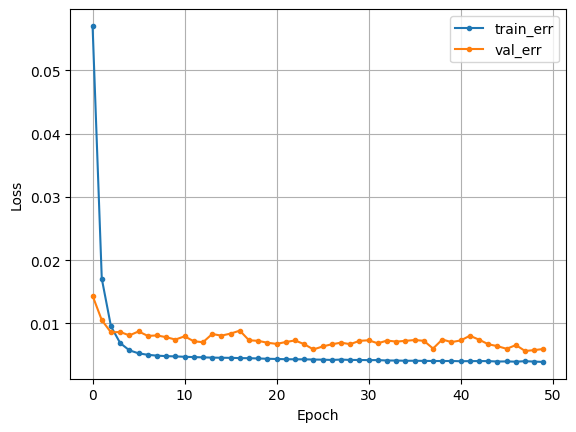

In [920]:
clear_session()

_, ts, nfeat = x_train.shape

model12_02 = Sequential([LSTM(12, input_shape = (ts, nfeat) ),
                         Dense(1)])
model12_02.summary()
model12_02.compile(optimizer = 'adam', loss = 'mse')
hist = model12_02.fit(x_train, y_train, epochs = 50, validation_data =(x_val,y_val), verbose = 0).history
dl_history_plot(hist)

In [921]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model12_02.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 [==============================] - 0s 3ms/step
MAE :  823.7477428877339
MAPE :  0.09030838292710408
R2 :  0.5043995220847852


In [922]:
x_test, y_test, scaler, y_min, y_max = make_testset3d(12, 7)

In [923]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model12_02.predict(x_test)
pred = pred * (y_max - y_min) + y_min
y_test2 = y_test * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_test2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_test2, pred))
print('R2 : ',r2_score(y_test2, pred))

1/1 [==============================] - 0s 17ms/step
MAE :  3028.322902513587
MAPE :  0.2511515390664088
R2 :  -0.2935906605901779


In [924]:
# price = 3: 8, 12: 6, 42: 5


# inv_simulator(y_test2, pred, 24111, 8) #CNN


# inv_simulator(y_test2, pred, 18965, 8) #CNN

# inv_simulator(y_test2, pred, 18606, 8) #LSTM

inv_simulator(y_test2, pred,18662, 8) #LSTM


일평균 재고량     : 22974.024
일평균 재고 금액  : 183792.192$
일평균 재고회전율 : 0.676
기회손실 수량     : -176.0
기회손실매출액     : -1408.0$


,y,pred,base_stock,close_stock,order,receive,lost
0,8208.0,6863.0,26870,18662,9075,8208,0.0
1,9083.0,7351.0,27745,18662,9332,9083,0.0
2,14392.0,9075.0,27737,13345,13057,9075,0.0
3,16478.0,9332.0,22677,6199,19714,9332,0.0
4,8715.0,7740.0,19256,10541,15537,13057,0.0
5,7505.0,7251.0,30255,22750,2661,19714,0.0
6,10453.0,7416.0,38287,27834,0,15537,0.0
7,8592.0,6749.0,30495,21903,6147,2661,0.0
8,11463.0,7612.0,21903,10440,17872,0,0.0
9,16763.0,9388.0,16587,0,26683,6147,-176.0


In [919]:

safe_stock = 18662

# y, pred, price 값 설정 (실제 데이터에 맞게 설정해야 함)
y = y_test2
pred = pred
price = 8

# lost_sum이 0이 되는 최소의 safe_stock 값 찾기
while True:
    inventory = inv_simulator(y, pred, safe_stock, price)
    lost_sum = inventory['lost'].sum()

    if lost_sum == 0:
        break

    safe_stock += 1

print(f"최소 safe_stock 값: {safe_stock}")

일평균 재고량     : 22786.738
일평균 재고 금액  : 182293.904$
일평균 재고회전율 : 0.681
기회손실 수량     : -474.0
기회손실매출액     : -3792.0$
일평균 재고량     : 22787.81
일평균 재고 금액  : 182302.48$
일평균 재고회전율 : 0.681
기회손실 수량     : -473.0
기회손실매출액     : -3784.0$
일평균 재고량     : 22788.881
일평균 재고 금액  : 182311.048$
일평균 재고회전율 : 0.681
기회손실 수량     : -472.0
기회손실매출액     : -3776.0$
일평균 재고량     : 22789.952
일평균 재고 금액  : 182319.616$
일평균 재고회전율 : 0.681
기회손실 수량     : -471.0
기회손실매출액     : -3768.0$
일평균 재고량     : 22791.024
일평균 재고 금액  : 182328.192$
일평균 재고회전율 : 0.681
기회손실 수량     : -470.0
기회손실매출액     : -3760.0$
일평균 재고량     : 22792.095
일평균 재고 금액  : 182336.76$
일평균 재고회전율 : 0.681
기회손실 수량     : -469.0
기회손실매출액     : -3752.0$
일평균 재고량     : 22793.167
일평균 재고 금액  : 182345.336$
일평균 재고회전율 : 0.681
기회손실 수량     : -468.0
기회손실매출액     : -3744.0$
일평균 재고량     : 22794.238
일평균 재고 금액  : 182353.904$
일평균 재고회전율 : 0.681
기회손실 수량     : -467.0
기회손실매출액     : -3736.0$
일평균 재고량     : 22795.31
일평균 재고 금액  : 182362.48$
일평균 재고회전율 : 0.681
기회손실 수량     : -466.0
기회손실매출액     : -3728.0$
일평균 재고